# Exploring the UTx000 Extension Beiwe Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Determining if participants were home when completing EMAs
We want to use the GPS data and timestamps of completed EMAs to see if the participant was home when they submitted their EMA. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import geopy.distance

# Data Import

## GPS Data
The GPS data are available in the ```processed``` directory and already downsampled to 5-minute increments.

In [3]:
gps = pd.read_csv('../data/processed/beiwe-gps-ux_s20.csv', index_col="timestamp", parse_dates=True, infer_datetime_format=True)
gps.drop(["utc","altitude","accuracy"],axis="columns",inplace=True)
gps.dropna(inplace=True)
gps.tail()

,lat,long,beiwe
timestamp,,,
2020-09-02 04:00:00,30.36724,-97.79323,zdpffrox
2020-09-02 04:05:00,30.36724,-97.79323,zdpffrox
2020-09-02 04:15:00,30.36721,-97.79321,zdpffrox
2020-09-02 04:25:00,30.36725,-97.79324,zdpffrox
2020-09-02 04:35:00,30.36718,-97.79324,zdpffrox


In [4]:
print(f"Number of participants: {len(gps['beiwe'].unique())}")

Number of participants: 52


## Address Information
We will need the address information from participants in order to determine if the participant is home or not.

In [5]:
info = pd.read_excel('../data/raw/utx000/admin/id_crossover.xlsx',sheet_name='beacon')
info.drop(["return_date","volume","housemates","roommates","n_rooms","no2_sensor","original_start","original_end","original_move","original_address","second address","lat3","long3","third address"],axis="columns",inplace=True)
info.dropna(subset=["beacon","lat","long"],inplace=True)
info.head()

,redcap,beiwe,beacon,start_date,end_date,move_date,lat,long,lat2,long2
0,0.0,zdpffrox,7.0,2020-06-01 00:00:00,2020-09-01,NaT,30.326815,-97.744665,30.367307,-97.793199
1,4.0,idbkjh8u,30.0,2020-06-11 10:07:00,2020-09-18,2020-08-15,30.240268,-97.709502,30.284696,-97.747237
2,10.0,kyj367pi,1.0,2020-06-08 13:00:00,2020-09-03,2020-07-31,30.295025,-97.744222,30.312614,-97.732338
3,12.0,lkkjddam,21.0,2020-06-10 11:21:00,2020-09-16,2020-08-02,30.588384,-97.428051,30.588371,-97.425863
4,15.0,rnse61g4,34.0,2020-06-11 12:01:00,2020-08-22,2020-08-08,30.285700,-97.744100,NaN,NaN


<div class="alert alert-block alert-info">

The issue we have is that some of these participants moved and we don't necessarily know if they brought their beacons or not. So we will start by removing them from the possible participants.
    
</div>

In [6]:
info = info[info["lat2"].isnull()].drop(["lat2","long2"],axis="columns")
info.sort_values("redcap",inplace=True)

In [7]:
print(f"Number of participants: {len(info['beiwe'].unique())}")

Number of participants: 21


## EMA Data
We need the morning and evening EMAs because we are interested in mood, not sleep quality this time ;) 

In [8]:
morning_ema = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
morning_ema.drop(["tst","sol","naw","restful"],axis="columns",inplace=True) # don't need and dropping to combine
evening_ema = pd.read_csv("../data/processed/beiwe-evening_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
ema = morning_ema.append(evening_ema)
ema.reset_index(inplace=True,drop=True)
ema.dropna(inplace=True)
ema.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,68,19.0
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,28,26.0
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,21,22.0
5,2020-05-13 10:32:23,mm69prai,1,0.0,1.0,1.0,1.0,62,13.0
6,2020-05-13 10:35:08,tlmlq19s,2,1.0,0.0,0.0,3.0,47,36.0


# Getting Location When EMA is Completed
We can create a function that gets the coordinates of the participants' locations when they complete the survey.

In [9]:
def get_coordinates(t, gps, pt, id_var="beiwe", window=10):
    """gets the gps coordinates for the participant the moment they complete an EMA"""
    gps_by_pt = gps[gps[id_var] == pt] # gps data for given participant
    if len(gps_by_pt) > 0:
        timeframe = [t - timedelta(minutes=window),t + timedelta(minutes=window)] # getting timeframe to average gps coordinates over
        gps_by_pt_in_window = gps_by_pt[timeframe[0]:timeframe[-1]] # restricting to timeframe
        if len(gps_by_pt_in_window) > 0:
            return [np.nanmean(gps_by_pt_in_window["lat"]), np.nanmean(gps_by_pt_in_window["long"])], gps_by_pt_in_window.index[-1] # returning mean lat/long coordinates
        
    return [np.nan, np.nan], np.nan

## Testing

In [10]:
get_coordinates(ema["timestamp"][0],gps,"qh34m4r9")

([33.161424999999994, -96.87419], Timestamp('2020-05-13 09:20:00'))

# Getting Time Only When Participants are Home
We can use the GPS coordinates from Beiwe and the addresses to filter out the data so that we can determine the time that participants are home.

In [11]:
def get_time_when_home(gps_df,info_df,radius=100,verbose=False):
    """returns gps data only from times when participants are home"""
    gps_with_distance = pd.DataFrame()
    for pt in info["beiwe"].unique():
        # getting data by pt
        gps_pt = gps_df[gps_df['beiwe'] == pt]
        info_pt = info_df[info_df['beiwe'] == pt]
        if verbose:
            print(f'Working for Participant {pt} - Beacon', int(info_pt['beacon'].values[0]))
        # getting pt address points
        lat_pt1 = info_pt['lat'].values[0]
        long_pt1 = info_pt['long'].values[0]
        coords_add_1 = (lat_pt1, long_pt1)
        # Getting distances to address from coordinates
        d1 = []
        for lat, long in zip(gps_pt["lat"].values,gps_pt["long"].values):
            d1.append(geopy.distance.distance(coords_add_1, (lat,long)).m)
            
        gps_pt["d1"] = d1
        gps_with_distance = gps_with_distance.append(gps_pt)
        
    return gps_with_distance[(gps_with_distance["d1"] < radius)], gps_with_distance

In [12]:
gps_home,gps_dist = get_time_when_home(gps,info,verbose=True)
print("Number of datapoints:",len(gps_home))

Working for Participant rnse61g4 - Beacon 34
Working for Participant xxvnhauv - Beacon 22
Working for Participant hxj6brwj - Beacon 28
Working for Participant xdbdrk6e - Beacon 24
Working for Participant hcpu5myv - Beacon 41
Working for Participant awa8uces - Beacon 26
Working for Participant rj4lxgvp - Beacon 48
Working for Participant nvtfpaor - Beacon 46
Working for Participant vr9j5rry - Beacon 25
Working for Participant 9jtzsuu8 - Beacon 15
Working for Participant 4i7679py - Beacon 44
Working for Participant 5fvmg226 - Beacon 23
Working for Participant tmexej5v - Beacon 29
Working for Participant xlw5ntd5 - Beacon 10
Working for Participant i4w8dx6l - Beacon 40
Working for Participant 745vq78e - Beacon 5
Working for Participant itmylz3g - Beacon 6
Working for Participant mm69prai - Beacon 13
Working for Participant qh34m4r9 - Beacon 19
Working for Participant 2xtqkfz1 - Beacon 32
Working for Participant i31pt4b4 - Beacon 11
Number of datapoints: 97959


# Inspecting Distances and Coordinates of Addresses

In [13]:
def get_common_coordinates(gps_df,pt):
    """gets the commonly occuring GPS coordinates"""
    gps_by_pt = gps_df[gps_df["beiwe"] == pt]
    
    try:
        lats = list(gps_by_pt["lat"].values)
        lat_mode = max(set(lats), key=lats.count)
        longs = list(gps_by_pt["long"].values)
        long_mode = max(set(longs), key=longs.count)
    except ValueError as e:
        print(e)
        return [np.nan,np.nan]
    
    return [lat_mode,long_mode]

In [14]:
def inpsect_distances(gps_with_d, pt, byvar="beiwe",ylim=1000):
    """Plots distances for participant"""
    df_to_plot = gps_with_d[gps_with_d[byvar] == pt]
    fig, ax = plt.subplots(figsize=(24,6))
    ax.scatter(df_to_plot.index,df_to_plot["d1"],s=5,color="black")
    # x-axis
    ax.set_xlim([datetime(2020,5,1),datetime(2020,9,1)])
    # y-axis
    ax.set_ylim([0,ylim])
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
        
    plt.show()
    plt.close()

Participant rnse61g4:
	From Address:	(30.2857,-97.7441)
	Estimate:	(30.2857,-97.7441)


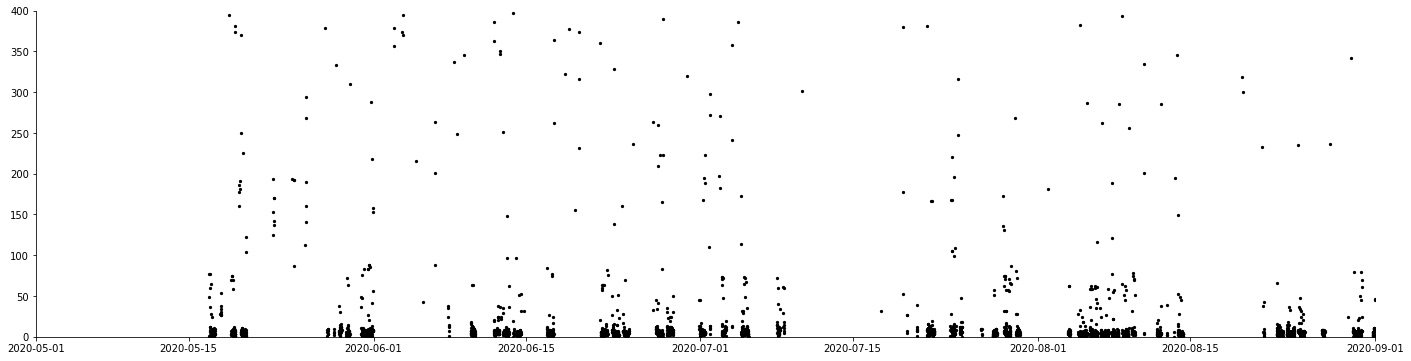

Participant xxvnhauv:
	From Address:	(30.29102,-97.7494)
	Estimate:	(30.29102,-97.7494)


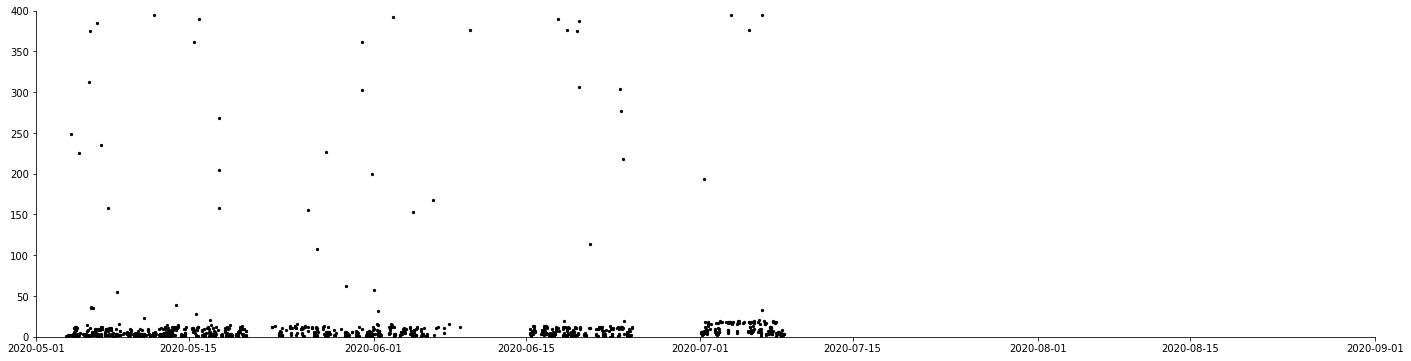

Participant hxj6brwj:
	From Address:	(30.28007,-97.74115)
	Estimate:	(30.28007,-97.74115)


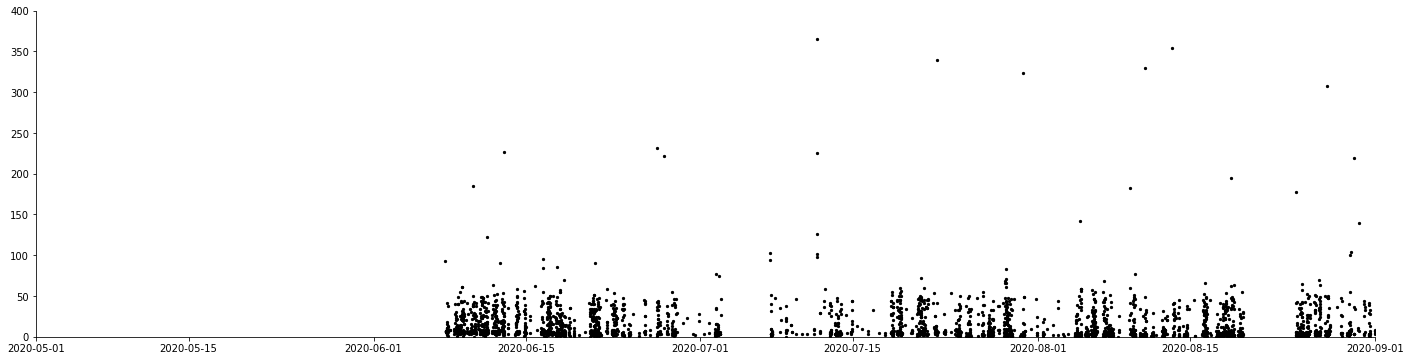

Participant xdbdrk6e:
	From Address:	(33.13661,-96.62536)
	Estimate:	(33.13661,-96.62536)


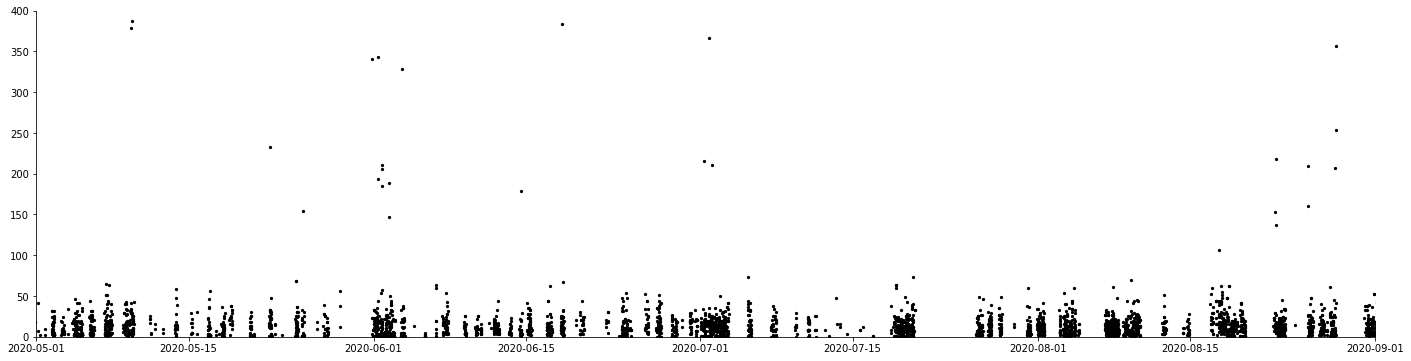

Participant hcpu5myv:
	From Address:	(32.70649,-97.69216)
	Estimate:	(32.70649,-97.69216)


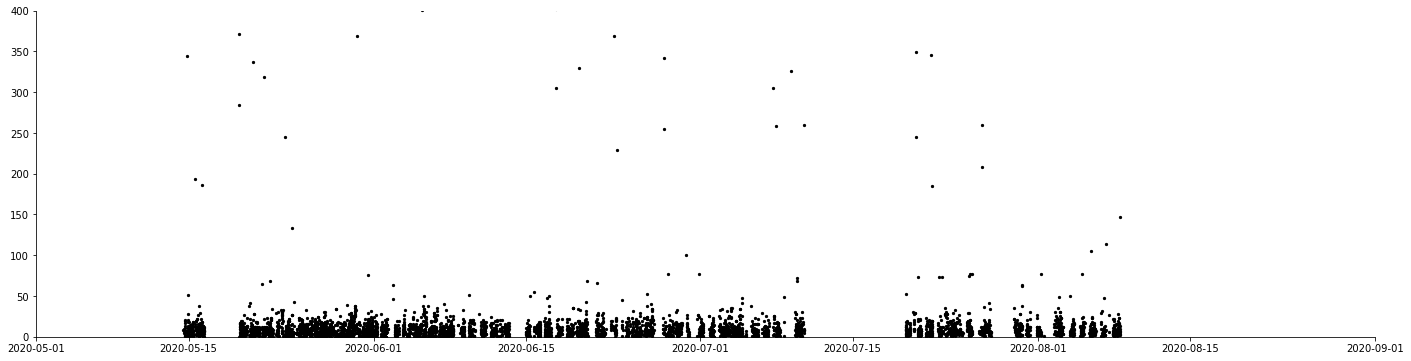

Participant awa8uces:
	From Address:	(30.04939,-95.5055)
	Estimate:	(30.04939,-95.5055)


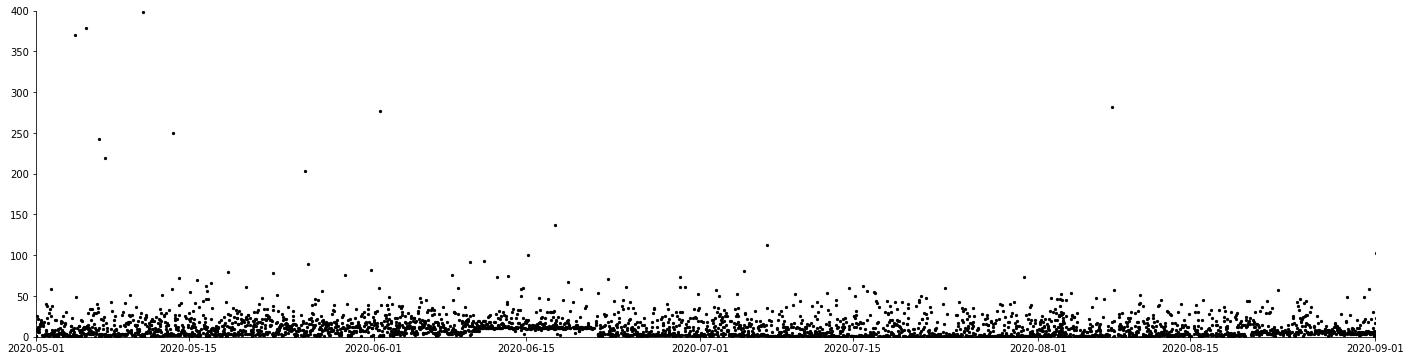

max() arg is an empty sequence
Participant rj4lxgvp:
	From Address:	(30.286894,-97.748909)
	Estimate:	(nan,nan)


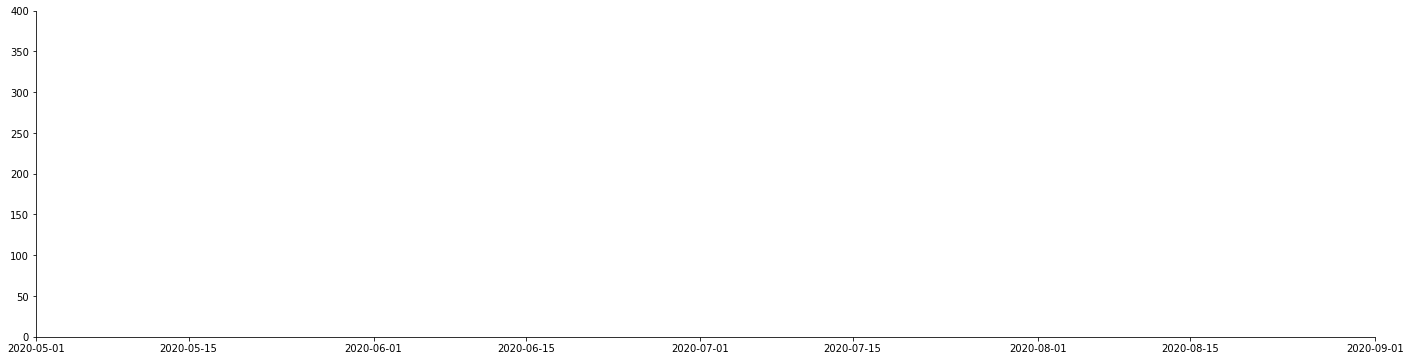

max() arg is an empty sequence
Participant nvtfpaor:
	From Address:	(27.602539,-99.463737)
	Estimate:	(nan,nan)


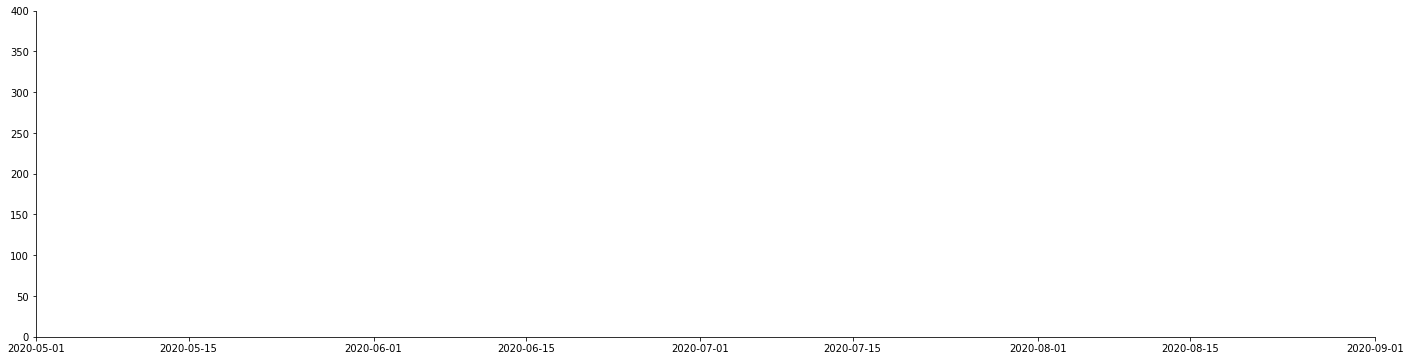

Participant vr9j5rry:
	From Address:	(30.35748,-97.75179)
	Estimate:	(30.35748,-97.75179)


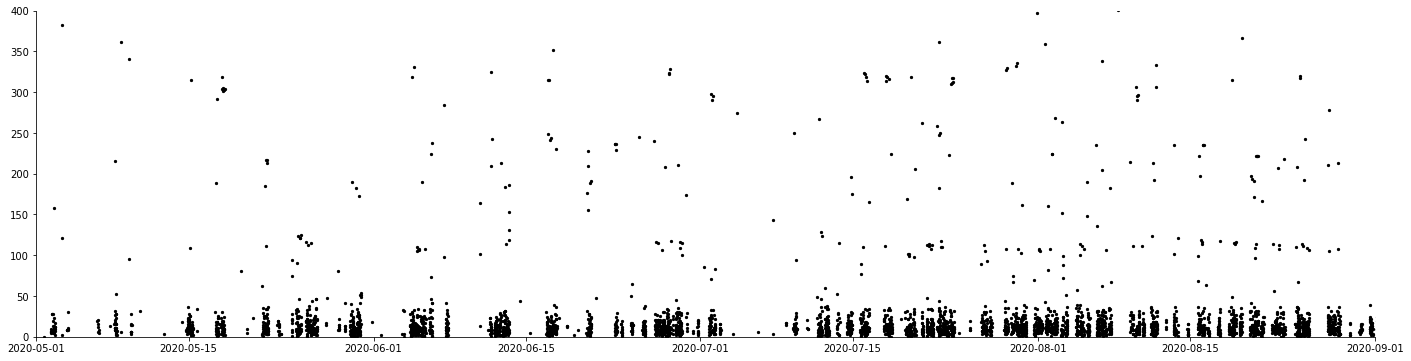

Participant 9jtzsuu8:
	From Address:	(33.142,-97.1135)
	Estimate:	(33.142,-97.1135)


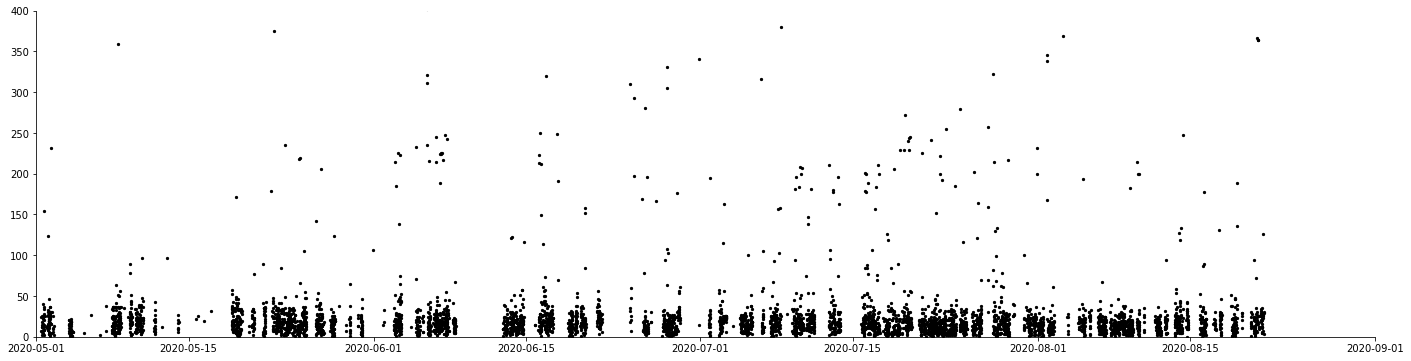

Participant 4i7679py:
	From Address:	(33.03598,-96.65369)
	Estimate:	(33.03598,-96.65369)


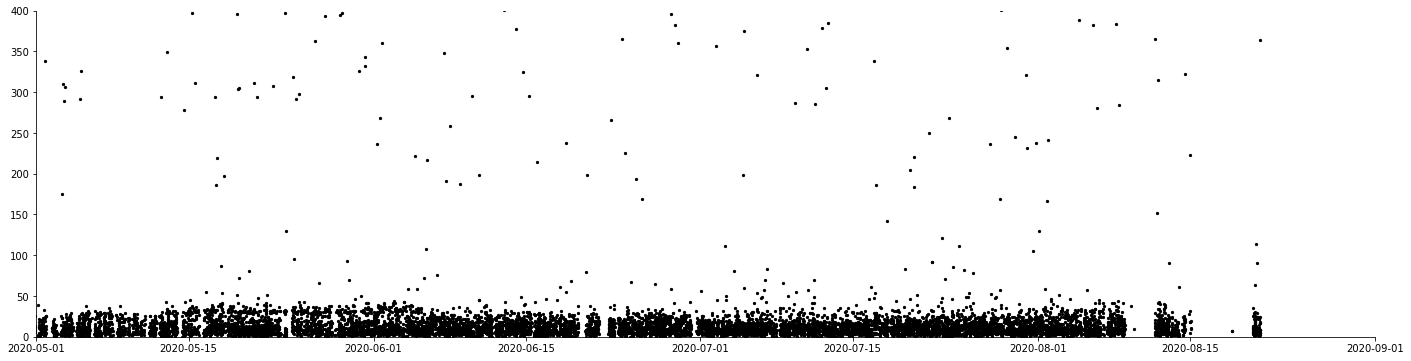

Participant 5fvmg226:
	From Address:	(30.2415,-97.71547)
	Estimate:	(30.2415,-97.71547)


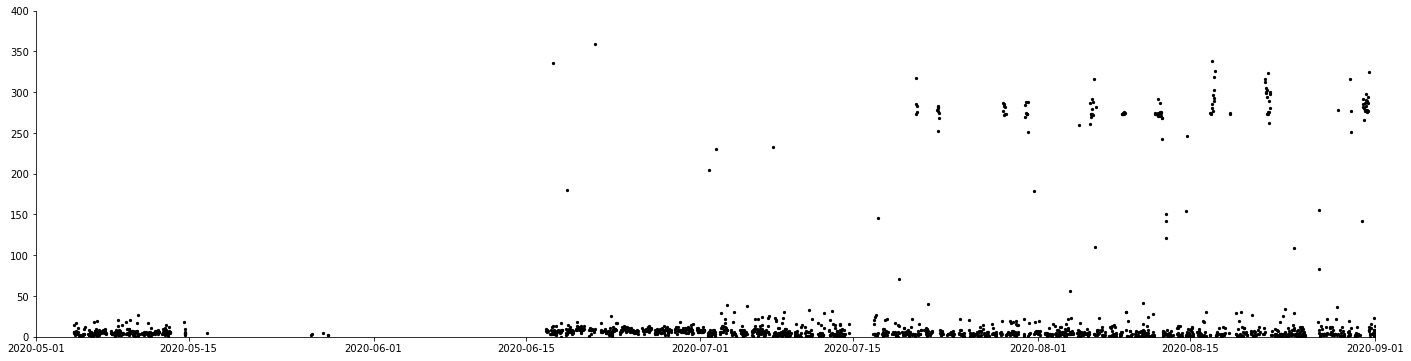

Participant tmexej5v:
	From Address:	(30.39634,-97.64425)
	Estimate:	(30.39634,-97.64425)


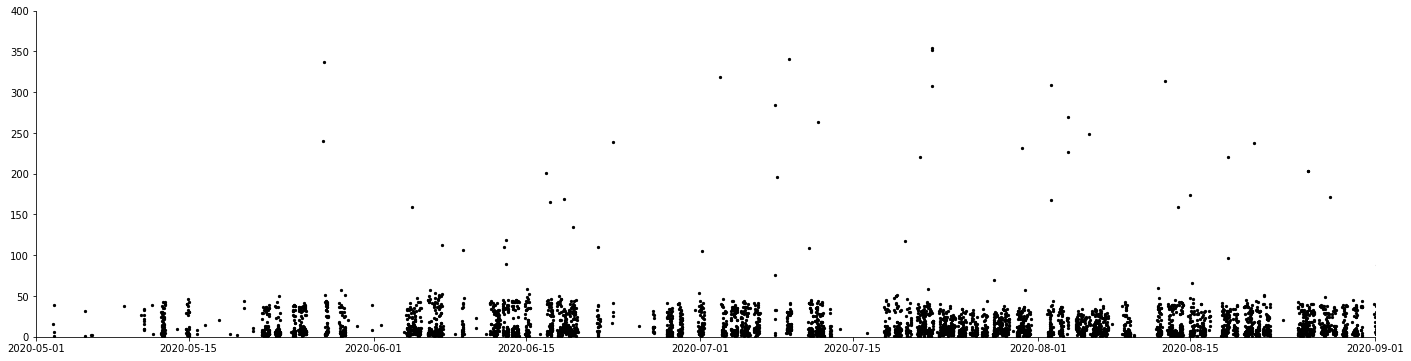

Participant xlw5ntd5:
	From Address:	(30.35162,-97.61234)
	Estimate:	(30.35162,-97.61234)


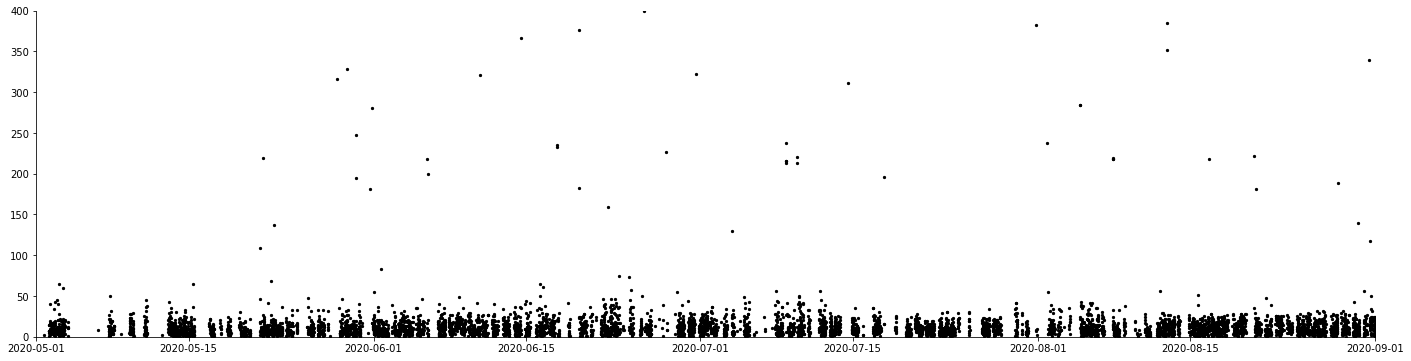

Participant i4w8dx6l:
	From Address:	(30.29359,-97.74406)
	Estimate:	(30.29359,-97.74406)


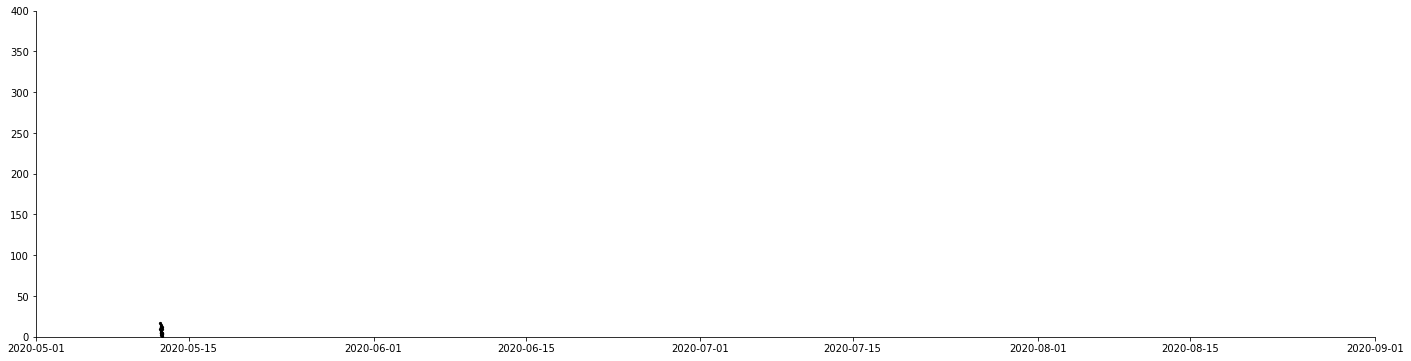

Participant 745vq78e:
	From Address:	(29.61562,-98.64459)
	Estimate:	(29.61562,-98.64459)


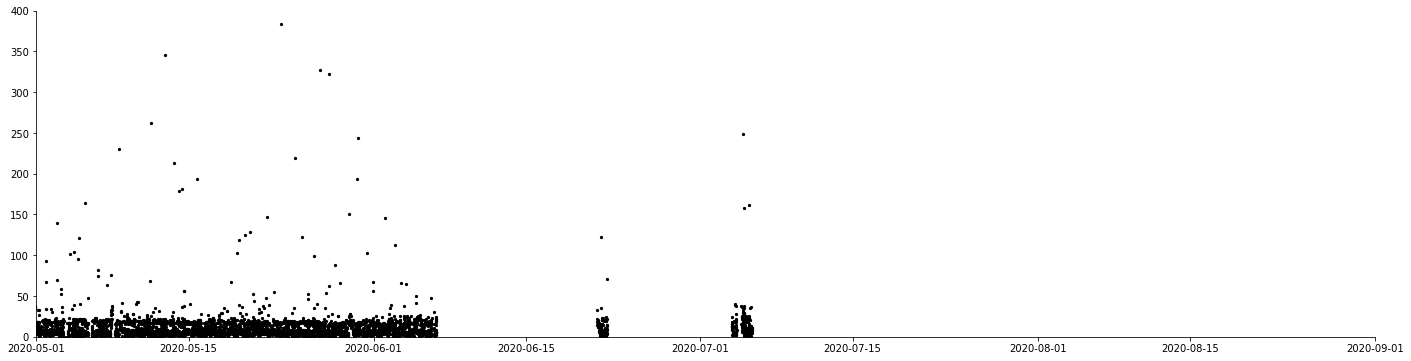

Participant itmylz3g:
	From Address:	(29.85539,-95.73908)
	Estimate:	(29.85539,-95.73908)


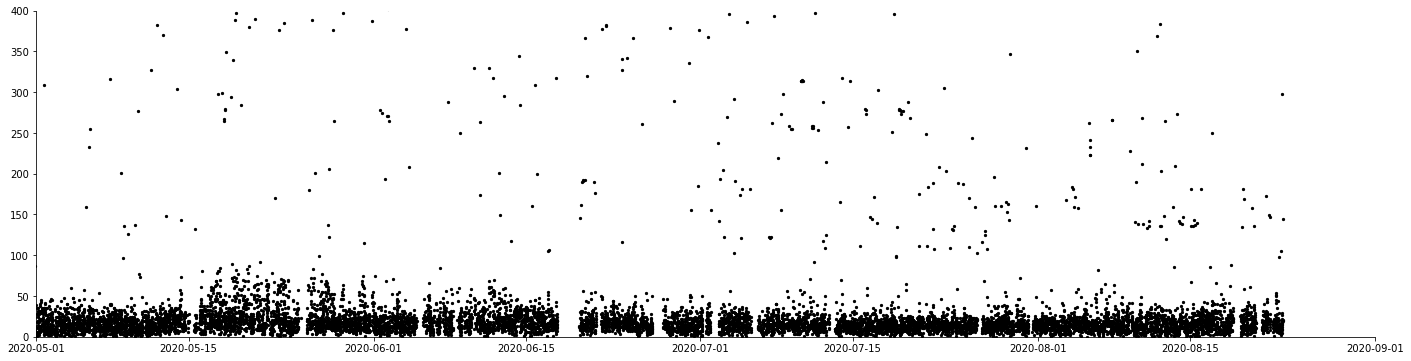

Participant mm69prai:
	From Address:	(30.28607,-97.71076)
	Estimate:	(30.28607,-97.71076)


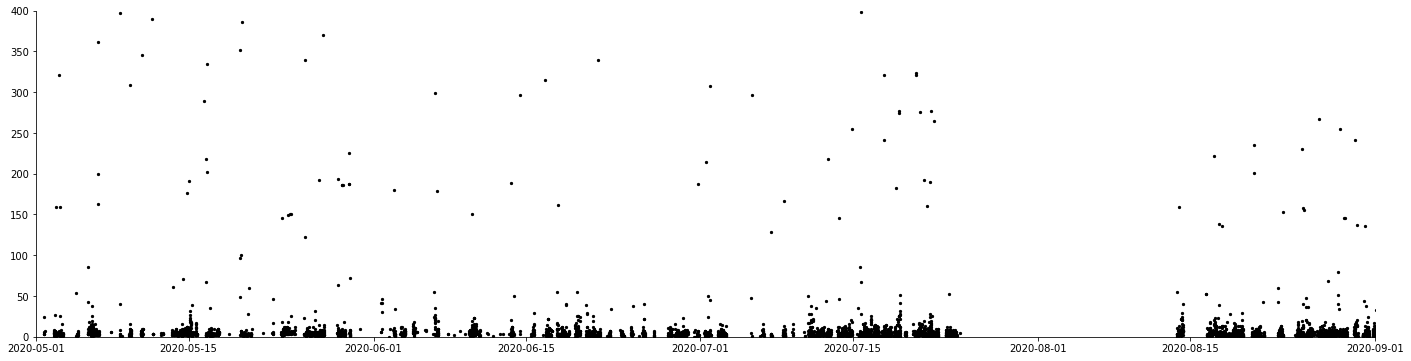

Participant qh34m4r9:
	From Address:	(33.16132,-96.87416)
	Estimate:	(33.16132,-96.87416)


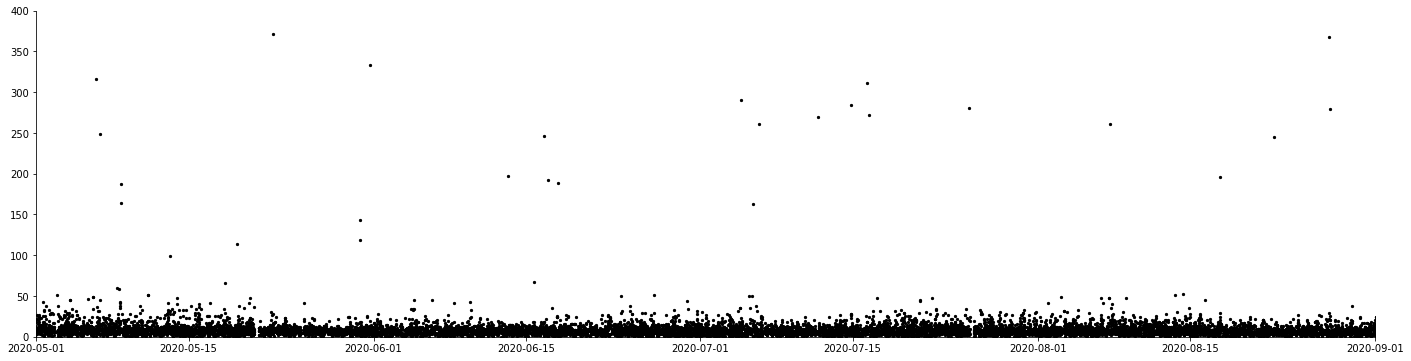

Participant 2xtqkfz1:
	From Address:	(32.92309,-96.9628)
	Estimate:	(32.92309,-96.9628)


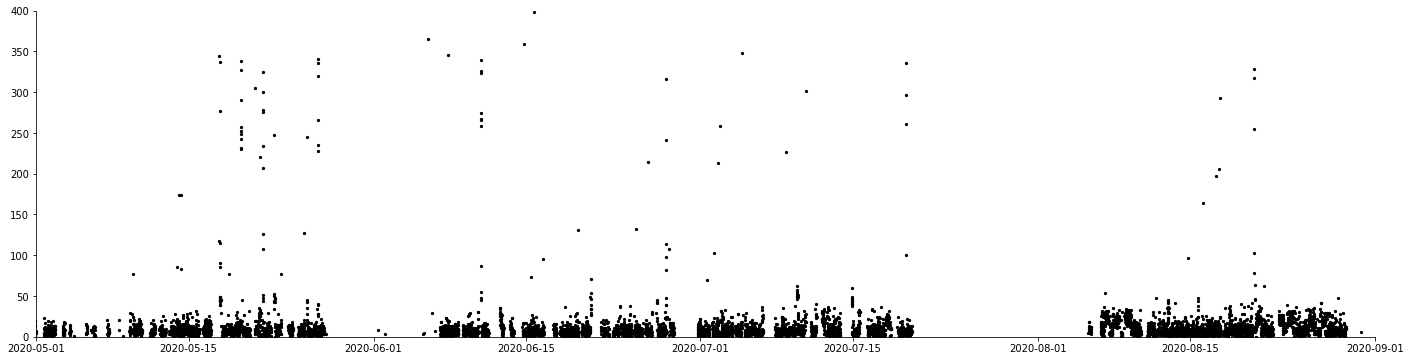

Participant i31pt4b4:
	From Address:	(30.29036,-97.75066)
	Estimate:	(30.29036,-97.75066)


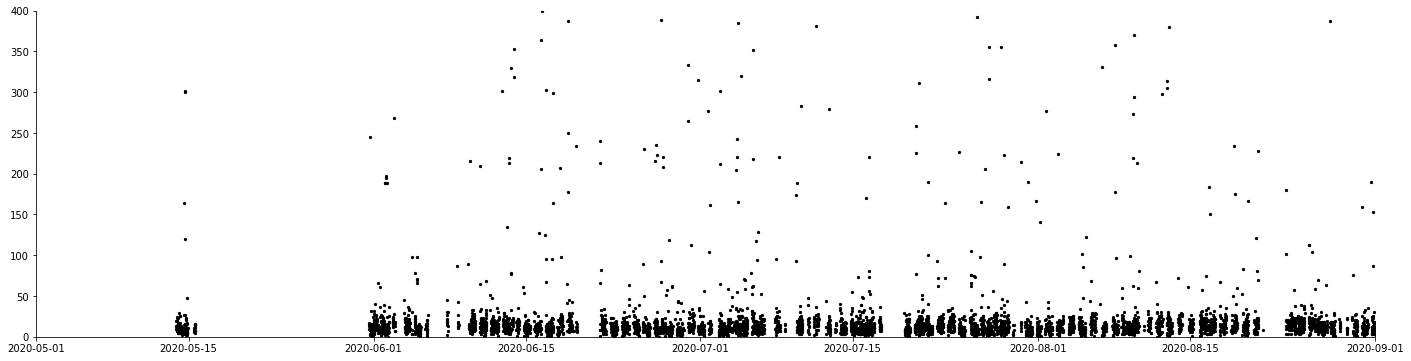

In [15]:
for pt in info["beiwe"].unique():
    coords = get_common_coordinates(gps,pt)
    info_by_pt = info[info["beiwe"] == pt]
    print(f"Participant {pt}:\n\tFrom Address:\t({round(info_by_pt['lat'].values[0],6)},{round(info_by_pt['long'].values[0],6)})\n\tEstimate:\t({round(coords[0],6)},{round(coords[1],6)})")
    inpsect_distances(gps_dist,pt,ylim=400)

# Checking if Participant was Home When Survey was Submitted

In [23]:
def get_ema_location(gps_df,ema_df):
    """appends the location to the ema dataframe"""
    ema_with_loc = pd.DataFrame()
    for pt in gps_df["beiwe"].unique():
        gps_home_by_pt = gps_df[gps_df["beiwe"] == pt]
        gps_home_by_pt["time"] = gps_home_by_pt.index
        gps_home_by_pt["dt"] = (gps_home_by_pt["time"] - gps_home_by_pt["time"].shift(1)).dt.total_seconds() / 60
        ema_by_pt = ema_df[ema_df["beiwe"] == pt]
        ema_submission = []
        home_starts = []
        ema_submits = []
        t_at_home = []
        for submission in ema_by_pt["timestamp"]:
            loc, timestamp = get_coordinates(submission,gps_home_by_pt,pt)
            if math.isnan(loc[0]):
                ema_submission.append("away")
                home_starts.append(np.nan)
                ema_submits.append(np.nan)
                t_at_home.append(0)
            else:
                ema_submission.append("home")
                ema_submits.append(timestamp)
                time_before = gps_home_by_pt[timestamp-timedelta(hours=1):timestamp]
                time_before = time_before[time_before["dt"] == 5]
                try:
                    t_at_home.append((timestamp - time_before.index[0]).total_seconds()/60)
                    home_starts.append(time_before.index[0])
                except IndexError:
                    t_at_home.append(0)
                    home_starts.append(timestamp)

        ema_by_pt["location"] = ema_submission
        ema_by_pt["time_home"] = home_starts
        ema_by_pt["ema_submitted"] = ema_submits
        ema_by_pt["duration"] = t_at_home
        ema_with_loc = ema_with_loc.append(ema_by_pt)
        
    return ema_with_loc

In [24]:
ema_loc = get_ema_location(gps_home,ema)
print("Number of Surveys Completed at Home:",len(ema_loc[ema_loc['location'] == 'home']))

In [33]:
home_only = ema_loc[ema_loc["location"] == "home"]
home_only.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,location,time_home,ema_submitted,duration
57,2020-05-17 09:54:09,rnse61g4,3,0.0,0.0,0.0,2.0,15,34.0,home,2020-05-17 09:10:00,2020-05-17 09:50:00,40.0
331,2020-05-31 20:54:26,rnse61g4,2,0.0,0.0,1.0,2.0,15,34.0,home,2020-05-31 20:20:00,2020-05-31 21:00:00,40.0
931,2020-06-24 10:30:45,rnse61g4,2,1.0,0.0,0.0,2.0,15,34.0,home,2020-06-24 10:05:00,2020-06-24 10:30:00,25.0
1187,2020-07-05 11:07:38,rnse61g4,2,0.0,0.0,0.0,1.0,15,34.0,home,2020-07-05 10:00:00,2020-07-05 11:00:00,60.0
1649,2020-07-24 11:13:19,rnse61g4,3,0.0,0.0,0.0,3.0,15,34.0,home,2020-07-24 11:10:00,2020-07-24 11:10:00,0.0


In [34]:
home_only["duration"].value_counts()

0.0     484
60.0     95
55.0     75
50.0     47
40.0     33
20.0     30
30.0     28
10.0     24
5.0      20
25.0     15
15.0      9
35.0      7
45.0      5
Name: duration, dtype: int64